In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
# import scanorama
import anndata as ad
import numpy as np
import scipy.sparse as sp
from scanpy.external.pp import mnn_correct
from combat.pycombat import pycombat
import scanorama

# Umap

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created PCA components in .obsm.X_pca


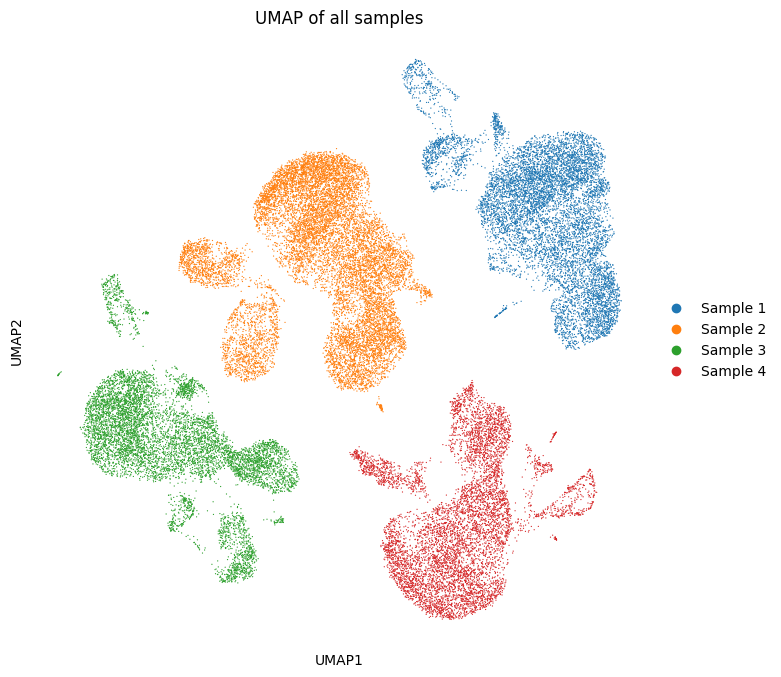

In [2]:
merged_adata = sc.read_h5ad('../data/merged.h5ad')

def calc_umap(adata, use_rep="X_pca"):
    if use_rep == "X_pca":
        sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)  # Select top 2000 HVGs
        sc.pp.pca(adata, n_comps=50, use_highly_variable=True)
        sc.pp.neighbors(adata, n_pcs=50)
        sc.tl.umap(adata)

        print('Created PCA components in .obsm.X_pca')
    
    # Run neighbors and UMAP
    sc.pp.neighbors(adata, use_rep=use_rep, n_neighbors=15)  # Use PCA representation
    sc.tl.umap(adata)
    return adata

def plot_umap(adata):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    sc.pl.umap(adata, color='sample', title='UMAP of all samples', show=False, ax=ax)
    # Modify legend labels to replace "_" with space
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_text(text.get_text().replace("sample", "Sample").replace("_", " "))
    plt.show()


    
adata_umap = calc_umap(merged_adata.copy())
plot_umap(adata_umap)
# adata_umap.write_h5ad('merged_umap.h5ad', compression='gzip')

# Batch effects correction - pycombat

In [4]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

# before = adata_combined.X.copy()
# sc.pp.combat(adata_combined, key='sample', inplace=True)

df_expression = pd.DataFrame(adata_combined.X.toarray(), index=adata_combined.obs.index, columns=adata_combined.var.index).T
# run pyComBat
df_corrected = pycombat(df_expression, adata_combined.obs['sample'].values)


# after = df_corrected
# print((before != after).sum())  # Count changes


Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created PCA components in .obsm.X_pca


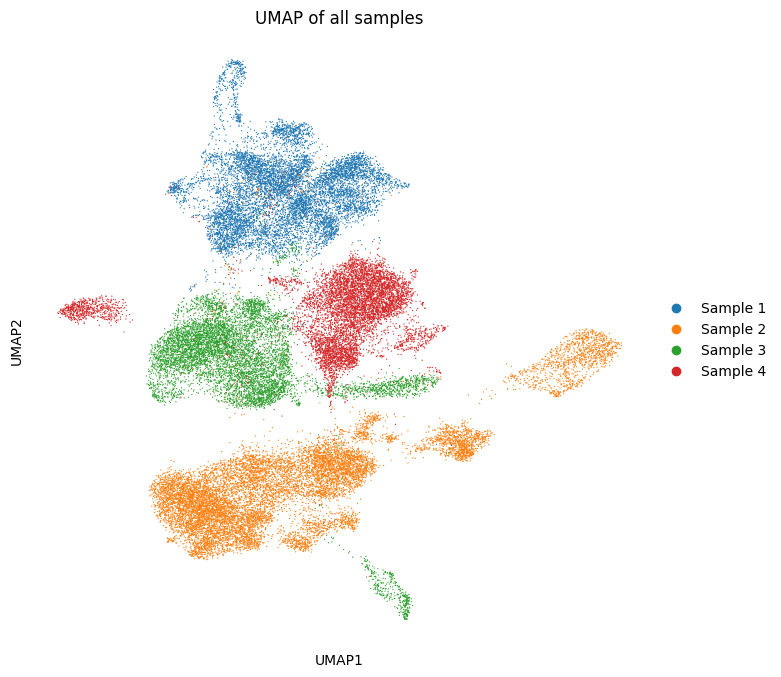

In [7]:
adata_corrected = adata_combined.copy()
adata_corrected.X = df_corrected.T.values
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat x4

837100000


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


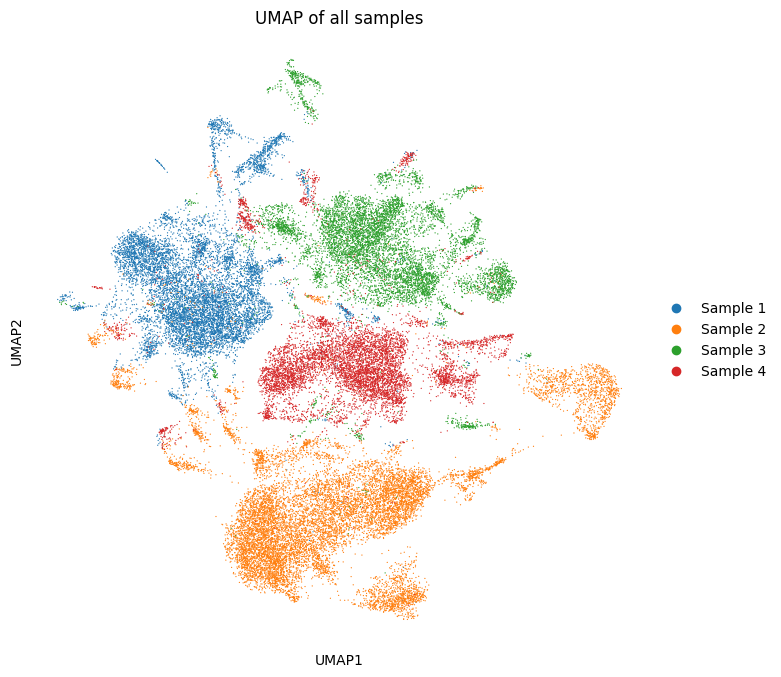

In [23]:
# 4 times

adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X.copy()
for i in range(4):
    sc.pp.combat(adata_combined, key='sample', inplace=True)
after = adata_combined.X
print((before != after).sum())  # Count changes
adata_corr_umap2 = calc_umap(adata_combined)
plot_umap(adata_corr_umap2)

# Batch effects correction - scanpy scanorama

In [16]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
corrected_data_list = scanorama.correct_scanpy(adata_list, return_dimred=True)  # output will contain .obsm['X_scanorama']
# after = adata_combined.X
# print((before != after).sum())  # Count changes
adata_corrected = ad.concat(corrected_data_list) # Reconstruct the AnnData object
after = adata_corrected.X
print((before != after).sum())  # Count changes

Found 22000 genes among all datasets
[[0.         0.00413311 0.00979541 0.0023315 ]
 [0.         0.         0.         0.00252257]
 [0.         0.         0.         0.016739  ]
 [0.         0.         0.         0.        ]]


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


152102972


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


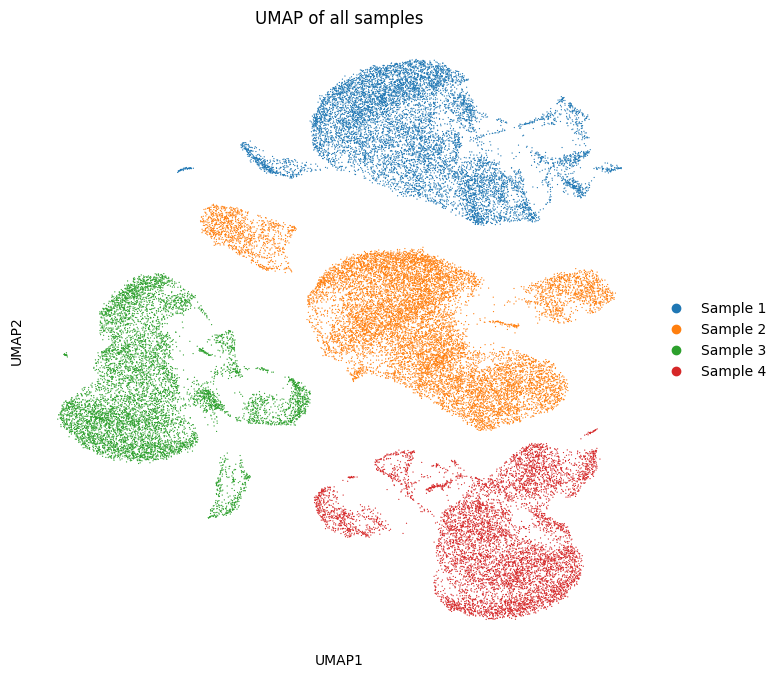

In [17]:
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy MNN correct

In [ ]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
adata_mnn_corrected, corrected_batches = mnn_correct(*adata_list, batch_key='batch')
# after = adata_combined.X
after = adata_corrected.X
print((before != after).sum())  # Count changes
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy pycombat - no normalisation

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


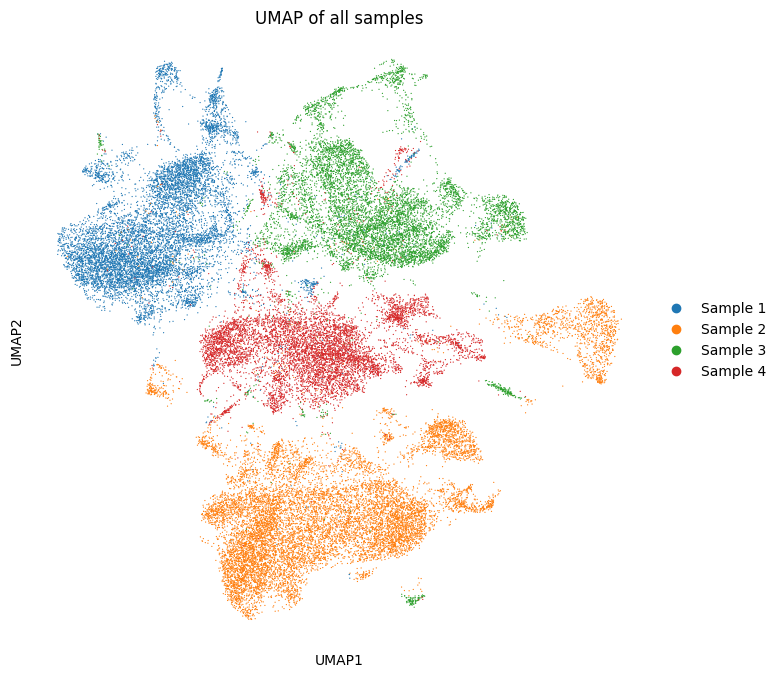

In [25]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat - with normalisation

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


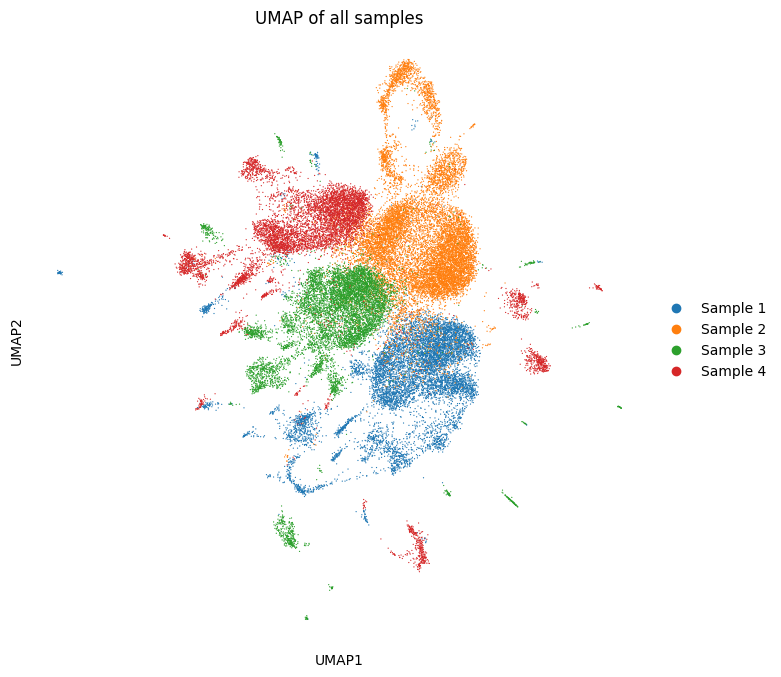

In [3]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
# Normalize and log-transform the raw counts
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Differential expression

In [ ]:
# Subset for the four cell types of interest
cell_types = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell']
adata_subset = adata_corrected[adata_corrected.obs['predicted.celltype'].isin(cell_types)].copy()

# Perform DE analysis for each cell type
results = {ct: dict() for ct in cell_types}
for cell_type in cell_types:
    cell_type_data = adata_subset[adata_subset.obs['predicted.celltype'] == cell_type]
    for sample in ['sample_1', 'sample_2', 'sample_3']:
        cell_type_data_sample = adata_subset[adata_subset.obs['sample'].isin([sample, 'sample_4'])]
    
        # Perform DE analysis
        sc.tl.rank_genes_groups(cell_type_data_sample, groupby='sample', reference='sample_4', method='wilcoxon')
    
        # Store results
        # Filter genes with significant adjusted p-value
        degs_df = sc.get.rank_genes_groups_df(cell_type_data_sample, group=sample)
        significant_degs = degs_df[degs_df['pvals_adj'] < 0.05]  # Adjust threshold as needed
        significant_degs = significant_degs[~significant_degs['logfoldchanges'].isna()]
        top_degs = significant_degs[(significant_degs['logfoldchanges'] > 0.5) | (significant_degs['logfoldchanges'] < -0.5) ]
        

        # Sort by log fold change or adjusted p-value
        top_degs = top_degs.sort_values(by='logfoldchanges', ascending=False)
        results[cell_type][sample] = top_degs
        print(len(significant_degs), len(top_degs))

# # Step 5: Save results
# for cell_type, df in results.items():
#     df.to_csv(f"DE_genes_{cell_type.replace(' ', '_')}.csv", index=False)

# print("Differentially expressed genes saved for each cell type.")


In [70]:
len(set(results['B cell']['sample_1']['names']).intersection(set(results['B cell']['sample_2']['names'])))

0

In [71]:
len(set(results['B cell']['sample_1']['names']).intersection(set(results['B cell']['sample_3']['names'])))

0

In [72]:
len(set(results['B cell']['sample_3']['names']).intersection(set(results['B cell']['sample_2']['names'])))

0

In [43]:
# Check differentially expressed genes inside control (just for sanity)
adata_subset = adata_corrected[adata_corrected.obs['predicted.celltype'].isin(['B cell'])].copy()
adata_subset = adata_subset[adata_subset.obs['sample'].isin(['sample_4'])]
np.random.seed(488)
adata_subset.obs.loc[:, 'half'] = [str(x) for x in np.random.randint(0, 2, size=(len(adata_subset)))]

sc.tl.rank_genes_groups(adata_subset, groupby='half', reference='1', method='wilcoxon')

degs_df = sc.get.rank_genes_groups_df(adata_subset, group='0')
significant_degs = degs_df[degs_df['pvals_adj'] < 0.05]  # Adjust threshold as needed
significant_degs = significant_degs[~significant_degs['logfoldchanges'].isna()]
significant_degs = significant_degs[significant_degs['logfoldchanges'] > 1]

# Sort by log fold change or adjusted p-value
top_degs = significant_degs.sort_values(by='logfoldchanges', ascending=False)
top_degs

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/pandas/core/indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


,names,scores,logfoldchanges,pvals,pvals_adj


In [ ]:
# Create a figure with 4 subplots
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns for 4 subplots
# axes = axes.flatten()  # Flatten the 2x2 array into a 1D array for easier indexing


# Loop through each cell type and plot in a subplot
for i, ct in enumerate(cell_types):
    adata_subset = adata_corrected[adata_corrected.obs['predicted.celltype'].isin([ct])].copy()

    # Plot heatmap for top genes
    sc.pl.heatmap(
        adata_subset, 
        var_names=results[ct]['sample_1'].head(20)['names'].values,  # Top 20 genes
        groupby='sample', 
        use_raw=False,
        show=True,  # Prevent automatic display
    )
    # axes[i].set_title(ct)  # Set the title for each subplot

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


In [68]:
results[ct]['sample_2'].head(20)['names'].values

array([], dtype=object)

In [69]:
results['B-cells']

KeyError: 'B-cells'